##**Determine whether the image is scenic or not from the image and the comment**##

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')

Mounted at /content/drive


Define the classifier : Must be the same as pretrained

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00


In [3]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

Read pretrained torch model

In [5]:
import torch
model_path = '/content/drive/MyDrive/scenic_model_bilal_new.pt'
classifier = ScenicClassifier(768)
classifier.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
classifier.eval()

ScenicClassifier(
  (embedding): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, 

Test on selected images

Saving Screenshot 2023-09-07 at 7.57.06 PM.png to Screenshot 2023-09-07 at 7.57.06 PM (1).png
User uploaded file "Screenshot 2023-09-07 at 7.57.06 PM (1).png" with length 4913275 bytes


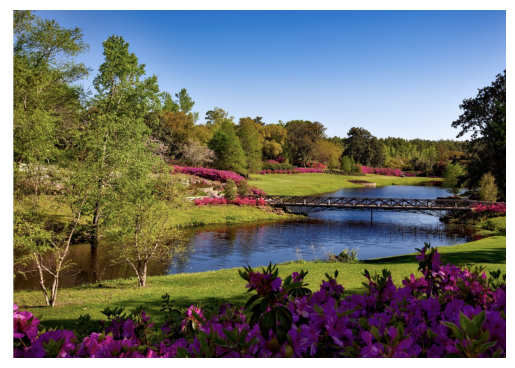

Enter the comment of the image : rough grass leading to water and a bridge over water
scenic


In [7]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
from torchvision.io import read_image
import io
import torchvision

uploaded = files.upload()
img_resize = transforms.Resize((384, 512))
label = ['not scenic', 'scenic']

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

  # load the image and convert it to RGB
  uploaded[fn]
  img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  comment = input("Enter the comment of the image : ")
  comment = comment.lower()
  encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)

  predict = classifier(encoding)
  print(label[torch.argmax(torch.squeeze(predict))])